In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings("ignore")

data_download = pd.read_csv(r"C:\Users\wojci\OneDrive - SGH\School_\DataScience\Projects\Audiobooks - customer churn rate\Audiobooks_data.csv",
                            header=None)

# Visualization

2 years of past data of the customers activity of audiobook site company

In [24]:
data_raw = pd.DataFrame(data = data_download)
#Naming the columns
data_raw.columns = ['ID', 'Book length (mins) overall', 'Book length (mins) avg', 'Price overall', 'Price average', 'Review', 'Review 10/10', 'Minutes listened', 'Completion', 'Support requests', 'Last visted minus Purchase date', 'Target']

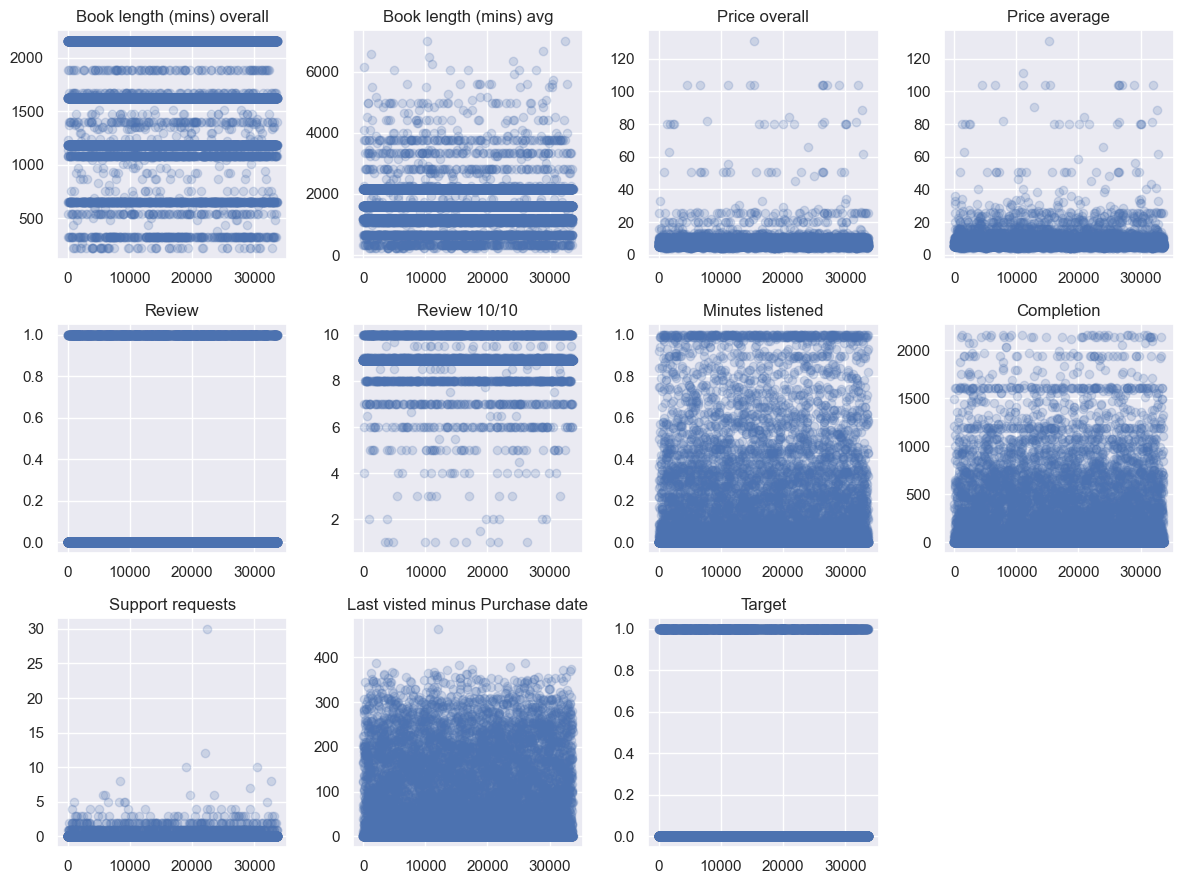

In [25]:
# Number of plots
n_plots = 11
n_cols = 4
n_rows = 3

# Create a figure and a set of subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(3*n_cols, 3*n_rows))  # Adjust figure size as needed

# Flatten the axs array for easy iteration, if there are multiple subplots
axs_flat = axs.flatten()

for i in range(n_plots):
    ax = axs_flat[i]
    ax.scatter(data_raw['ID'], data_raw[data_raw.columns[i+1]], alpha=0.2)
    ax.set_title(data_raw.columns[i+1])

# Hide any unused subplots
for i in range(n_plots, len(axs_flat)):
    axs_flat[i].set_visible(False)

plt.tight_layout()  # Adjust layout so labels don't overlap
plt.show()

# Preprocessing
1. Balancing, standardizing and shuffling the data
2. train/val/test split
3. create .npz

In [26]:
unscaled_inputs_all = data_raw[data_raw.columns[1:-1]]
targets_all = data_raw[data_raw.columns[[-1]]]

In [27]:
unscaled_inputs_all.shape

(14084, 10)

1.1 Balance the dataset

In [28]:
num_one_targets = int(targets_all.sum()) #2237
zero_targets_counter = 0
indices_to_remove = []


# matching the number of 0 to number of 1 in the target variable
for i in range(len(targets_all)):
    if targets_all.iat[i,0] == 0:
        zero_targets_counter += 1
        if zero_targets_counter > num_one_targets:
            indices_to_remove.append(i)

unscaled_inputs_equal_priors = unscaled_inputs_all.drop(index= indices_to_remove, axis = 0) #4474
targets_equal_priors = targets_all.drop(index= indices_to_remove, axis=0)

1.2 Standardize

In [29]:
scaled_inputs = preprocessing.scale(unscaled_inputs_equal_priors)

1.3 Shuffle

In [30]:
shuffled_indices = np.arange(scaled_inputs.shape[0])
np.random.shuffle(shuffled_indices)

shuffled_inputs = scaled_inputs[shuffled_indices]
shuffled_targets = np.array(targets_equal_priors)[shuffled_indices]

Train/Validation/Test split   (80%-10%-10%)

In [31]:
samples_count = shuffled_inputs.shape[0]

train_samples_count = int(0.8 * samples_count)
validation_samples_count = int(0.1 * samples_count)
test_samples_count = int(0.1 * samples_count)

train_inputs = shuffled_inputs[:train_samples_count]
train_targets = shuffled_targets[:train_samples_count]

validation_inputs = shuffled_inputs[train_samples_count:train_samples_count + validation_samples_count]
validation_targets = shuffled_targets[train_samples_count:train_samples_count + validation_samples_count]

test_inputs = shuffled_inputs[train_samples_count + validation_samples_count:]
test_targets = shuffled_targets[train_samples_count + validation_samples_count:]


print(np.sum(train_targets), train_samples_count, np.sum(train_targets) / train_samples_count)
print(np.sum(validation_targets), validation_samples_count, np.sum(validation_targets) / validation_samples_count)
print(np.sum(test_targets), test_samples_count, np.sum(test_targets) / test_samples_count)

1806 3579 0.5046102263202011
205 447 0.45861297539149887
226 447 0.5055928411633109


Save for later use

In [32]:
#np.savez('Audiobooks_data_train', inputs=train_inputs, targets=train_targets)
#np.savez('Audiobooks_data_validation', inputs=validation_inputs, targets=validation_targets)
#np.savez('Audiobooks_data_test', inputs=test_inputs, targets=test_targets)

# Model Creation

In [68]:
input_size = 10
output_size = 2
hiddenlayer_size = 200

model = tf.keras.Sequential([
                            tf.keras.layers.Dense(hiddenlayer_size, activation='relu'), 
                            tf.keras.layers.Dense(hiddenlayer_size, activation='relu'),
                            tf.keras.layers.Dense(output_size, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

NUM_EPOCHS = 100

BATCH_SIZE = 50

EARLY_STOPPING = tf.keras.callbacks.EarlyStopping(patience=2)

model.fit(train_inputs, 
          train_targets,
          batch_size = BATCH_SIZE,
          epochs = NUM_EPOCHS,
          callbacks = [EARLY_STOPPING],
          validation_data = (validation_inputs, validation_targets),
          verbose = 2)

Epoch 1/100
72/72 - 1s - loss: 0.4460 - accuracy: 0.7603 - val_loss: 0.3703 - val_accuracy: 0.8121 - 878ms/epoch - 12ms/step
Epoch 2/100
72/72 - 0s - loss: 0.3680 - accuracy: 0.8019 - val_loss: 0.3561 - val_accuracy: 0.8076 - 126ms/epoch - 2ms/step
Epoch 3/100
72/72 - 0s - loss: 0.3580 - accuracy: 0.8025 - val_loss: 0.3538 - val_accuracy: 0.7897 - 201ms/epoch - 3ms/step
Epoch 4/100
72/72 - 0s - loss: 0.3499 - accuracy: 0.8108 - val_loss: 0.3521 - val_accuracy: 0.8121 - 220ms/epoch - 3ms/step
Epoch 5/100
72/72 - 0s - loss: 0.3416 - accuracy: 0.8195 - val_loss: 0.3511 - val_accuracy: 0.8233 - 175ms/epoch - 2ms/step
Epoch 6/100
72/72 - 0s - loss: 0.3354 - accuracy: 0.8159 - val_loss: 0.3486 - val_accuracy: 0.8121 - 132ms/epoch - 2ms/step
Epoch 7/100
72/72 - 0s - loss: 0.3354 - accuracy: 0.8150 - val_loss: 0.3322 - val_accuracy: 0.8188 - 127ms/epoch - 2ms/step
Epoch 8/100
72/72 - 0s - loss: 0.3458 - accuracy: 0.8120 - val_loss: 0.3389 - val_accuracy: 0.8255 - 131ms/epoch - 2ms/step
Epoch 9

In [70]:
test_loss, test_accuracy = model.evaluate(test_inputs, test_targets)

14/14 [==============================] - 0s 2ms/step - loss: 0.3644 - accuracy: 0.7969
